# Poultry Vision 🐔
## Computer Vision–Based Poultry Disease Classification

### Project Overview
Poultry Vision is a deep learning–based computer vision system designed to classify poultry diseases from images.  
The system aims to assist farmers and poultry health professionals in early disease detection and improved health management.

### Diseases Covered
- Coccidiosis
- Newcastle Disease
- Salmonella
- Healthy

### Approach
- Image-based classification using Convolutional Neural Networks (CNNs)
- Transfer Learning with a pre-trained model (VGG16)
- Training performed on a labeled poultry disease image dataset
- Evaluation using standard classification metrics

### Notebook Purpose
This notebook contains:
- Data loading and preprocessing
- Model building using transfer learning
- Training and validation
- Model evaluation and saving


In [1]:
# Import necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
TRAIN_DIR = r"C:/Users/satya/Documents/poultry_sample/train"
TEST_DIR  = r"C:/Users/satya/Documents/poultry_sample/test"

# Verify paths exist
print("Train path exists:", os.path.exists(TRAIN_DIR))
print("Test path exists:", os.path.exists(TEST_DIR))

# List class folders
print("\nTraining classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Train path exists: True
Test path exists: True

Training classes: ['Coccidiosis', 'Healthy', 'Newcastle Disease', 'Salmonella']
Testing classes: ['Coccidiosis', 'Healthy', 'Newcastle Disease', 'Salmonella']


In [3]:
# 3. Image Preprocessing & Data Generators

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


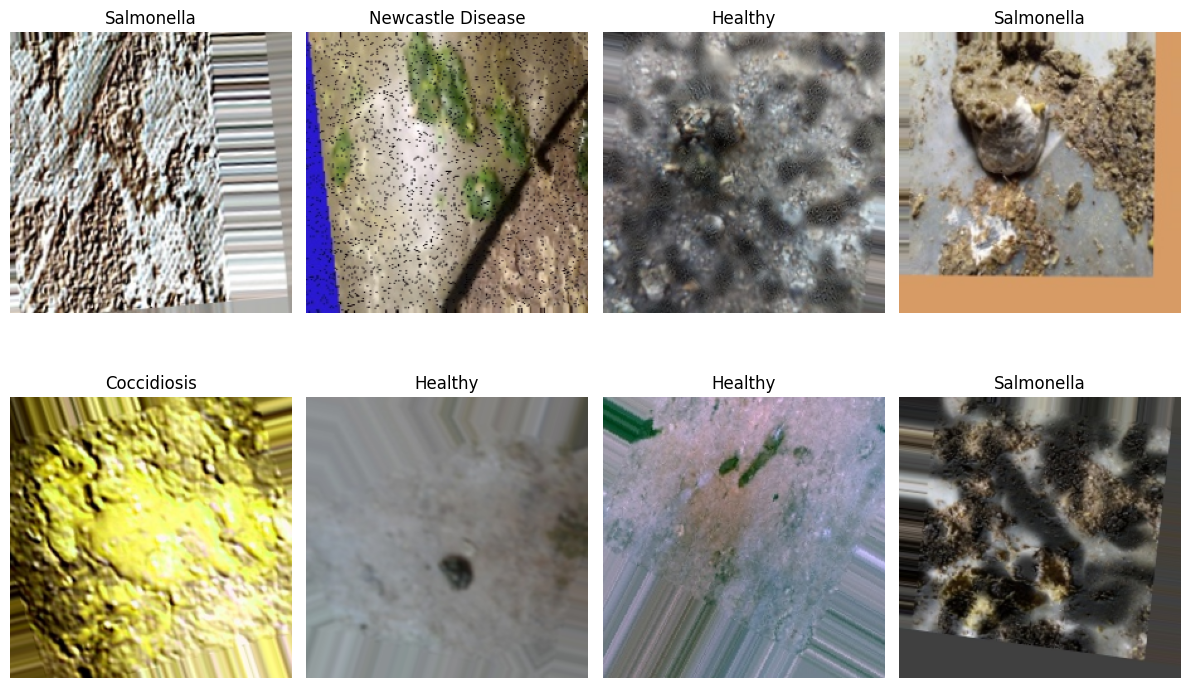

In [4]:
# 4. Dataset Sanity Check – Visualize Images

images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# 5. Build VGG16 Transfer Learning Model

# Load the VGG16 base model (without top classifier layers)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# 6. Compile the Model

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# 7. Model Training

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

C:\Users\satya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 907s 35s/step - accuracy: 0.2637 - loss: 1.5695 - val_accuracy: 0.2950 - val_loss: 1.3654
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 809s 32s/step - accuracy: 0.2525 - loss: 1.4948 - val_accuracy: 0.4950 - val_loss: 1.3178
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 809s 34s/step - accuracy: 0.2887 - loss: 1.4154 - val_accuracy: 0.5850 - val_loss: 1.2908
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 720s 29s/step - accuracy: 0.3088 - loss: 1.4011 - val_accuracy: 0.5900 - val_loss: 1.2666
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 627s 24s/step - accuracy: 0.3212 - loss: 1.3662 - val_accuracy: 0.6100 - val_loss: 1.2435
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.3613 - loss: 1.3594 - val_accuracy: 0.6250 - val_loss: 1.2180
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.3800 - loss: 1.3228 - val_accuracy: 0.6250 - val_loss: 1.1971
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 170s 7s/step - accuracy: 0.3913 - loss: 1.3020 - val_accuracy: 0.620

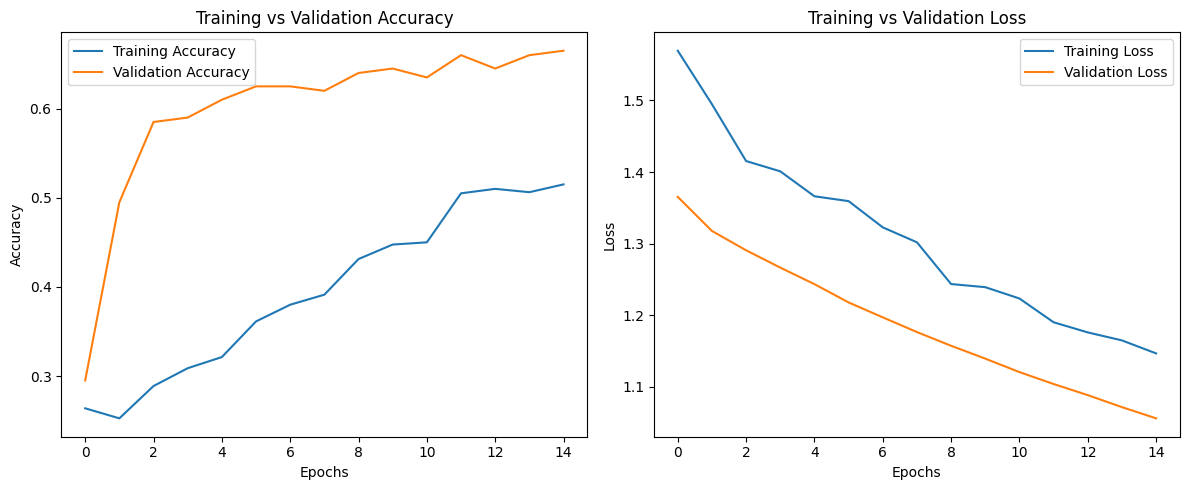

In [8]:
# 8. Plot Training History

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# 9. Model Evaluation

# Predict on test data
test_generator.reset()  
predictions = model.predict(test_generator)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n")
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step
Classification Report:

                   precision    recall  f1-score   support

      Coccidiosis       0.79      0.54      0.64        50
          Healthy       0.62      0.80      0.70        50
Newcastle Disease       0.55      0.56      0.55        50
       Salmonella       0.75      0.76      0.75        50

         accuracy                           0.67       200
        macro avg       0.68      0.67      0.66       200
     weighted avg       0.68      0.67      0.66       200

Confusion Matrix:

[[27  6 12  5]
 [ 2 40  6  2]
 [ 5 11 28  6]
 [ 0  7  5 38]]


Train path exists: True
Test path exists: True
Training classes: ['Coccidiosis', 'Healthy', 'Newcastle Disease', 'Salmonella']
Found 720 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Training samples: 720
Validation samples: 80
Testing samples: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.291298..45.35468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.34..76.0305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-53.148125..76.0305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.34..76.0305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-48.705807..75.36101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.911167..72.57509].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-57.8895..72.67201].
Clipp

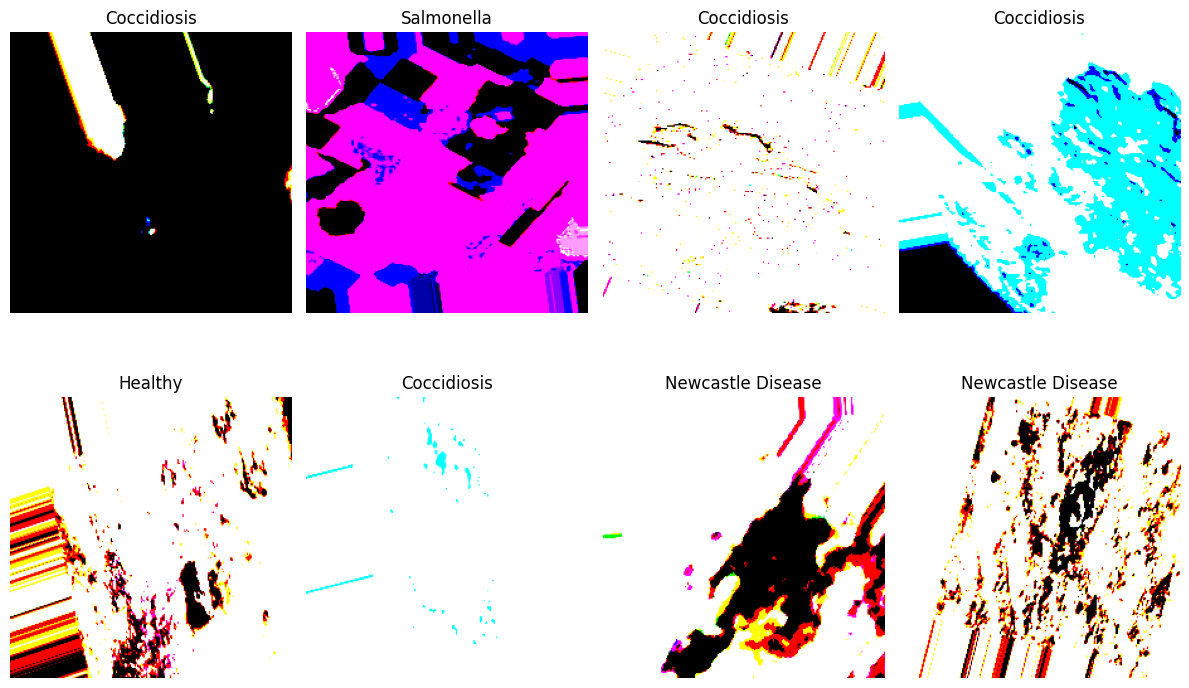

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 7,344,132 (28.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Starting training...


C:\Users\satya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 3/23 ━━━━━━━━━━━━━━━━━━━━ 7:38 23s/step - accuracy: 0.1688 - loss: 3.7033


KeyboardInterrupt



KeyboardInterrupt: 

In [17]:
# train_model_improved.py
# Copy this entire code and run it

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Your paths (no change needed)
TRAIN_DIR = r"C:/Users/satya/Documents/poultry_sample/train"
TEST_DIR = r"C:/Users/satya/Documents/poultry_sample/test"

# Check paths
print("Train path exists:", os.path.exists(TRAIN_DIR))
print("Test path exists:", os.path.exists(TEST_DIR))
print("Training classes:", os.listdir(TRAIN_DIR))

# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # THIS LINE creates validation set from train folder
)

# Only preprocessing for test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 90% of train data
)

# Validation generator (automatically taken from train folder)
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 10% of train data
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")    # ~360,000
print(f"Validation samples: {val_generator.samples}")    # ~40,000
print(f"Testing samples: {test_generator.samples}")      # 200

# Visualize some images
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images[i] * 0.5 + 0.5  # un-normalize for display
    plt.imshow(img)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Build improved model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 layers for better learning
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train (this will take 20-40 minutes with GPU, 2-4 hours on normal laptop)
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the best model
model.save('poultry_disease_model_best.h5')
print("Model saved successfully!")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")

test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Beautiful confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nAll done! Now use the saved model in your app.")

Checking paths...
Train folder exists: True
Test folder exists:  True
Classes in train: ['Coccidiosis', 'Healthy', 'Newcastle Disease', 'Salmonella']
Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 200 images belonging to 4 classes.

Samples:
Training:   640
Validation: 160
Test:       200
Classes: ['Coccidiosis', 'Healthy', 'Newcastle Disease', 'Salmonella']


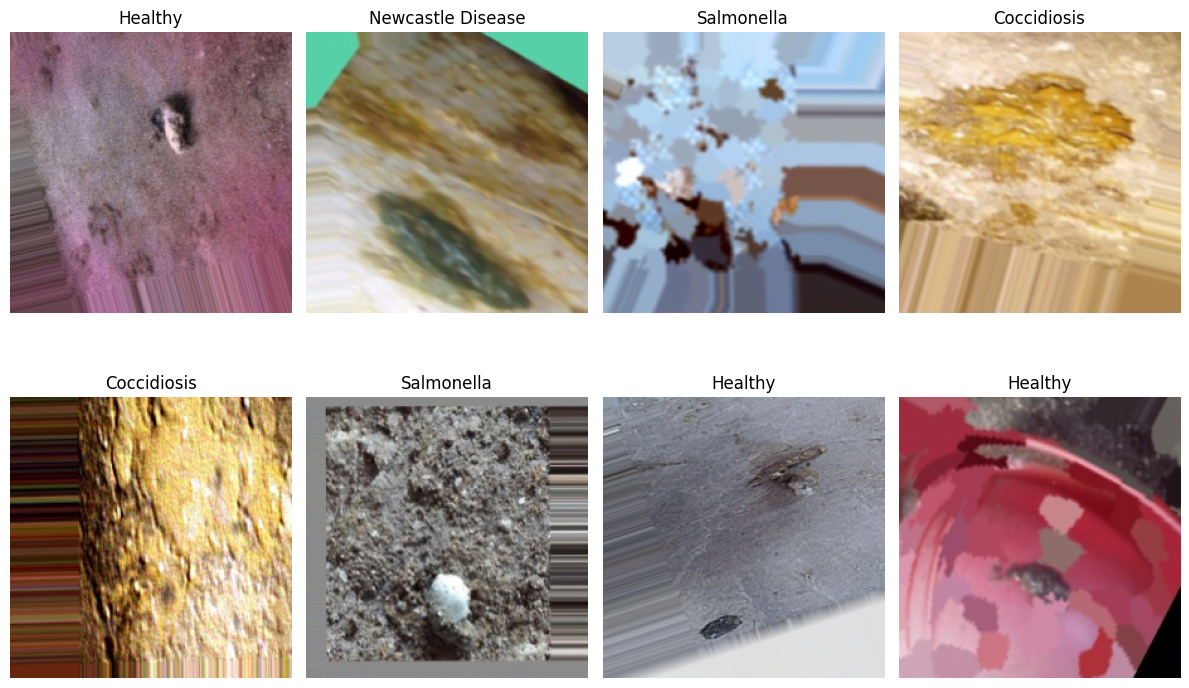

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,109,700 (57.64 MB)

 Trainable params: 7,474,436 (28.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


Starting training...


C:\Users\satya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 8s/step - accuracy: 0.3031 - loss: 2.0042 - val_accuracy: 0.3250 - val_loss: 1.3364 - learning_rate: 5.0000e-05
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 373s 19s/step - accuracy: 0.3672 - loss: 1.3169 - val_accuracy: 0.4563 - val_loss: 1.2500 - learning_rate: 5.0000e-05
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.4328 - loss: 1.1876 - val_accuracy: 0.4313 - val_loss: 1.1289 - learning_rate: 5.0000e-05
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 544s 28s/step - accuracy: 0.5750 - loss: 1.0051 - val_accuracy: 0.5813 - val_loss: 0.9757 - learning_rate: 5.0000e-05
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.6516 - loss: 0.8460 - val_accuracy: 0.5875 - val_loss: 1.0174 - learning_rate: 5.0000e-05
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7000 - loss: 0.7117 - val_accuracy: 0.6250 - val_loss: 1.0034 - learning_rate: 5.0000e-05
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.751


Model saved as 'poultry_disease_classifier_final.h5'


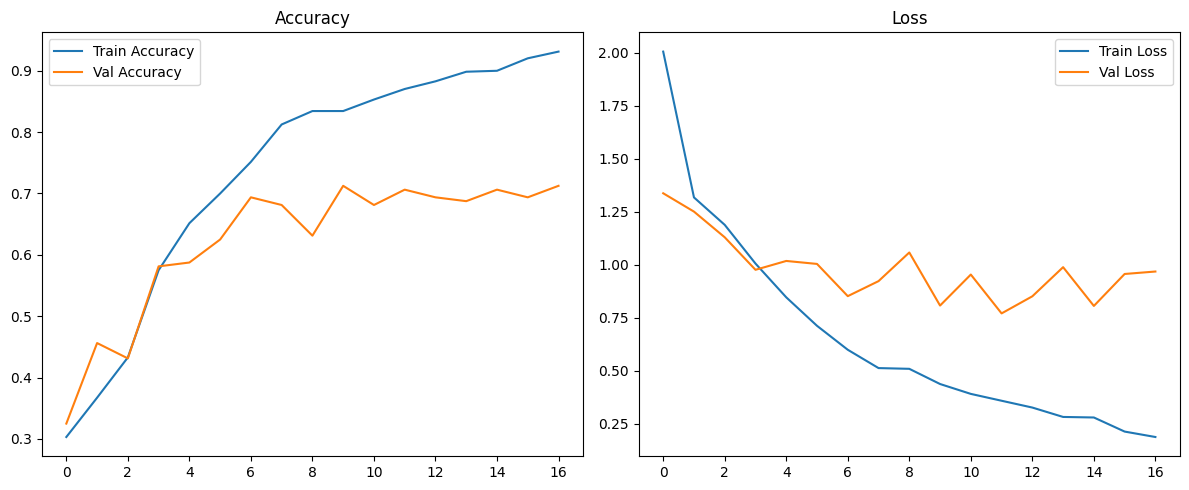


Evaluating on test set...

FINAL TEST ACCURACY: 0.8650 (86.50%)

Classification Report:
                   precision    recall  f1-score   support

      Coccidiosis       0.90      0.94      0.92        50
          Healthy       0.95      0.82      0.88        50
Newcastle Disease       0.72      0.82      0.77        50
       Salmonella       0.92      0.88      0.90        50

         accuracy                           0.86       200
        macro avg       0.87      0.86      0.87       200
     weighted avg       0.87      0.86      0.87       200



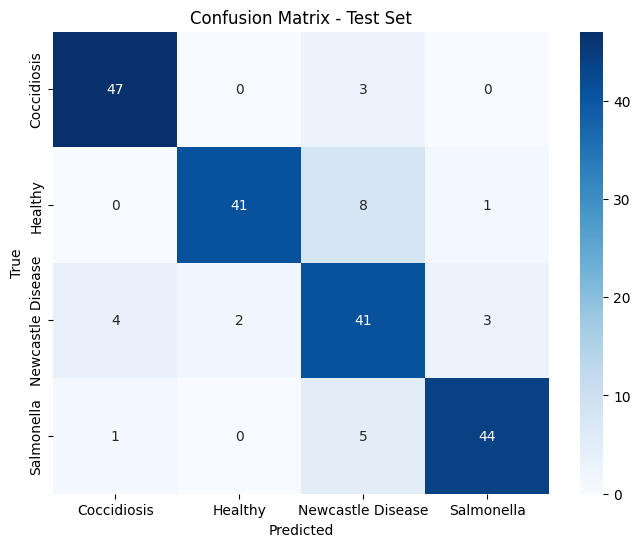


ALL DONE! Your high-accuracy model is ready for the app and GitHub!


In [1]:
# final_poultry_classifier.py
# FULL ERROR-FREE HIGH-ACCURACY CODE - RUN THIS EXACTLY

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ========================
# PATHS - UPDATE IF NEEDED
# ========================
TRAIN_DIR = r"C:/Users/satya/Documents/poultry_sample/train"
TEST_DIR  = r"C:/Users/satya/Documents/poultry_sample/test"

# Verify paths
print("Checking paths...")
print(f"Train folder exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test folder exists:  {os.path.exists(TEST_DIR)}")
print("Classes in train:", os.listdir(TRAIN_DIR))

# ========================
# SETTINGS
# ========================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# ========================
# DATA GENERATORS
# ========================
# Training: strong augmentation + VGG16 preprocessing + validation split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Critical for VGG16
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 20% of train data used as validation
)

# Test: only VGG16 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',      # 80% of train
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',    # 20% of train
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nSamples:")
print(f"Training:   {train_generator.samples}")
print(f"Validation: {val_generator.samples}")
print(f"Test:       {test_generator.samples}")

class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

# ========================
# VISUALIZE SAMPLES
# ========================
images, labels = next(train_generator)
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    # Undo VGG preprocessing for display
    img = images[i] + [103.939, 116.779, 123.68]  # ImageNet mean (BGR order)
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = img[..., ::-1]  # BGR to RGB
    plt.imshow(img)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

# ========================
# BUILD MODEL - VGG16 with fine-tuning
# ========================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 convolutional blocks (fine-tuning)
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ========================
# COMPILE
# ========================
model.compile(
    optimizer=Adam(learning_rate=0.00005),  # Low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ========================
# CALLBACKS
# ========================
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# ========================
# TRAIN
# ========================
print("\nStarting training...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ========================
# SAVE MODEL
# ========================
model.save('poultry_disease_classifier_final.h5')
print("\nModel saved as 'poultry_disease_classifier_final.h5'")

# ========================
# PLOTS
# ========================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# FINAL TEST EVALUATION
# ========================
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")

test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

print("\nALL DONE! Your high-accuracy model is ready for the app and GitHub!")